<a href="https://www.kaggle.com/code/andrewbremner/predict-cirrhosis-s3e26-pytorch-flexible-model?scriptVersionId=157600585" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e26/sample_submission.csv
/kaggle/input/playground-series-s3e26/train.csv
/kaggle/input/playground-series-s3e26/test.csv


# Explore data
### Read in Data

In [2]:
df = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv')

In [3]:
# No missing data
df.isnull().sum()

id               0
N_Days           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
Status           0
dtype: int64

## Split catagorical and continuous columns

In [4]:
cont_cols = df.describe().columns
cont_cols = cont_cols.drop(['id'])
cat_cols = df.dtypes[df.dtypes == 'object'].index.drop('Status')
y_col = ['Status']

### Catagorical Data
Leaving as catagories evebn though they are mostly hot coded available

In [5]:
for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [6]:
df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Drug          7905 non-null   category
 1   Sex           7905 non-null   category
 2   Ascites       7905 non-null   category
 3   Hepatomegaly  7905 non-null   category
 4   Spiders       7905 non-null   category
 5   Edema         7905 non-null   category
dtypes: category(6)
memory usage: 47.2 KB


In [7]:
# Convert to numpy array the tensor for NN
cats = np.stack([df[col].cat.codes.values for col in cat_cols],axis=1)
cats = torch.tensor(cats, dtype=torch.int64)

In [8]:
cats

tensor([[0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 1, 1, 2],
        ...,
        [0, 0, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0]])

### Continuous Data

In [9]:
# Convert to numpy array for NN
conts = np.stack([df[col].values for col in cont_cols],axis=1)
conts = torch.tensor(conts, dtype=torch.float)

In [10]:
conts

tensor([[9.9900e+02, 2.1532e+04, 2.3000e+00,  ..., 3.9400e+02, 9.7000e+00,
         3.0000e+00],
        [2.5740e+03, 1.9237e+04, 9.0000e-01,  ..., 3.6100e+02, 1.1000e+01,
         3.0000e+00],
        [3.4280e+03, 1.3727e+04, 3.3000e+00,  ..., 1.9900e+02, 1.1700e+01,
         4.0000e+00],
        ...,
        [1.5760e+03, 2.5873e+04, 2.0000e+00,  ..., 2.0000e+02, 1.2700e+01,
         2.0000e+00],
        [3.5840e+03, 2.2960e+04, 7.0000e-01,  ..., 2.2100e+02, 1.0600e+01,
         4.0000e+00],
        [1.9780e+03, 1.9237e+04, 7.0000e-01,  ..., 3.3600e+02, 1.0300e+01,
         3.0000e+00]])

### Label

In [11]:
df['Status'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7905 entries, 0 to 7904
Series name: Status
Non-Null Count  Dtype 
--------------  ----- 
7905 non-null   object
dtypes: object(1)
memory usage: 61.9+ KB


In [12]:
df['Status'].dtype

dtype('O')

In [13]:
df['Status'] = df['Status'].astype('category')

In [14]:
y = torch.tensor(df['Status'].cat.codes, dtype=torch.int64)

In [15]:
y

tensor([2, 0, 2,  ..., 2, 2, 0])

## Plots and Visualization

In [16]:
df[list(cont_cols)+['Status']]

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,999,21532,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,2574,19237,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,3428,13727,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,2576,18460,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,788,16658,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7900,1166,16839,0.8,309.0,3.56,38.0,1629.0,79.05,224.0,344.0,9.9,2.0,C
7901,1492,17031,0.9,260.0,3.43,62.0,1440.0,142.00,78.0,277.0,10.0,4.0,C
7902,1576,25873,2.0,225.0,3.19,51.0,933.0,69.75,62.0,200.0,12.7,2.0,D
7903,3584,22960,0.7,248.0,2.75,32.0,1003.0,57.35,118.0,221.0,10.6,4.0,D


In [17]:
# Interesting plot but it takes a while to get plotted out
# sns.pairplot(data=df[list(cont_cols)+['Status']], hue='Status')

# Model Class Creation

In [18]:
# Tabular model combined now
class TabluarModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p = 0.5):

        # layers = [200,100,50] FLEXIBLE!
        super().__init__()

        self.embeds = nn.ModuleList([nn.Embedding(ni,nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum([nf for ni,nf in emb_szs])
        n_in = n_emb + n_cont

        for i in layers:
            #layerlist.append(nn.ReLU())
            layerlist.append(nn.Linear(n_in,i))
            #layerlist.append(nn.LogSoftmax(dim=1))
            #layerlist.append(nn.GELU())
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.ReLU())
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1],out_sz))
        layerlist.append(nn.Softmax(dim=1))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []

        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x,x_cont],1)
        x = self.layers(x)
        return x

In [19]:
# Embeddings
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size,min(50,(size+1)//2)) for size in cat_szs]
emb_szs

[(2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (3, 2)]

### Make model Instance

In [20]:
model = TabluarModel(emb_szs = emb_szs, 
                     n_cont = conts.shape[1], 
                     out_sz = 3, 
                     layers = [32,16],
                     p = 0.3)

In [21]:
model

TabluarModel(
  (embeds): ModuleList(
    (0-4): 5 x Embedding(2, 1)
    (5): Embedding(3, 2)
  )
  (emb_drop): Dropout(p=0.3, inplace=False)
  (bn_cont): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=19, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=16, out_features=3, bias=True)
    (9): Softmax(dim=1)
  )
)

# Criterion and Optimizer

In [22]:
weights = y.bincount()/y.bincount().sum()
weights_reorg = weights.clone()
weights_reorg[0] = weights[1] + weights[2]
weights_reorg[1] = weights[2] + weights[0]
weights_reorg[2] = weights[0] + weights[1]
weights_reorg

tensor([0.3719, 0.9652, 0.6629])

In [23]:
#weights = y.bincount()/y.bincount().sum()

criterion = nn.CrossEntropyLoss(weight=weights_reorg) # Classification
#criterion = nn.NLLLoss(weight=weights_reorg) # Classification

optimizer = torch.optim.Adam(model.parameters(),lr=0.0002,weight_decay=0.01)

## Split into a train and test from the training for optimization

In [24]:
batch_size = int(len(df)*0.8)
test_size = len(df) - batch_size

In [25]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [26]:
#len(cat_train)

# Train!

In [27]:
import time
start_time = time.time()
epochs = 1001
losses = []

for i in range(epochs):
    i+=1

    y_pred = model(cat_train, con_train)
    #loss = torch.sqrt(criterion(y_pred,y_train)) #Regression
    #print(y_pred)
    loss = criterion(y_pred, y_train) # Classification
    losses.append(loss)

    if i%100 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print(f'Training took {duration/60} minutes')

epoch:   1  loss: 1.10328948
epoch: 101  loss: 1.01272655
epoch: 201  loss: 0.95744342
epoch: 301  loss: 0.92094827
epoch: 401  loss: 0.89242256
epoch: 501  loss: 0.87176055
epoch: 601  loss: 0.85644263
epoch: 701  loss: 0.83862650
epoch: 801  loss: 0.83042938
epoch: 901  loss: 0.82035720
epoch: 1001  loss: 0.81578410
Training took 0.19019766648610434 minutes


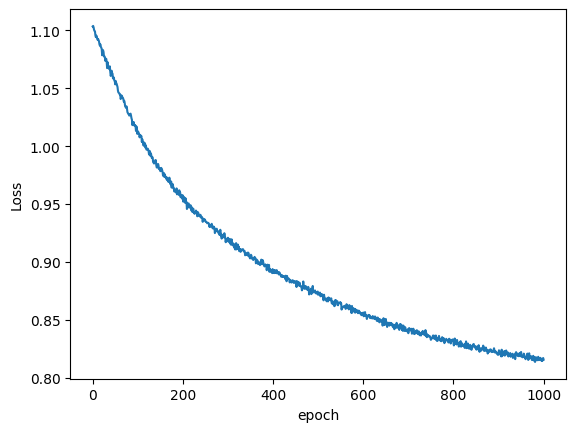

In [28]:
plt.plot(range(epochs), [x.item() for x in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

# Validate the model

In [29]:
with torch.no_grad():

    y_val = model(cat_test, con_test)

    loss = criterion(y_val, y_test)

In [30]:
y_val_out = [x.argmax().item() for x in y_val]

In [31]:
confusion_matrix(y_test,y_val_out)

array([[783,   0, 221],
       [ 27,   0,  46],
       [ 88,   0, 416]])

In [32]:
log_loss(y_test,y_val)

0.7270153509091851

In [33]:
#con_train[0]

In [34]:
#test_conts[0]

# Test set prep

In [35]:
#cat_cols = cat_cols.drop(['Status'])

In [36]:
cat_cols

Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')

In [37]:
for cat in cat_cols:
    df_test[cat] = df_test[cat].astype('category')

# Convert to numpy array the tensor for NN
test_cats = np.stack([df_test[col].cat.codes.values for col in cat_cols],axis=1)
test_cats = torch.tensor(test_cats, dtype=torch.int64)
# Convert to numpy array for NN
test_conts = np.stack([df_test[col].values for col in cont_cols],axis=1)
test_conts = torch.tensor(test_conts, dtype=torch.float)

In [38]:
with torch.no_grad():
    y_val_final = model(test_cats, test_conts)


In [39]:
y_val_final

tensor([[0.8553, 0.0546, 0.0901],
        [0.8671, 0.0498, 0.0832],
        [0.0069, 0.0061, 0.9870],
        ...,
        [0.8628, 0.0620, 0.0751],
        [0.7755, 0.1499, 0.0745],
        [0.0483, 0.0362, 0.9155]])

# Output Data

In [40]:
columns = ['id','Status_C','Status_CL','Status_D']

In [41]:
df_test['id']
pandas_tensor = pd.DataFrame(y_val_final.numpy(), columns=['Status_C','Status_CL','Status_D'])
output_df = pd.concat([df_test['id'],pandas_tensor],axis=1)
output_df

,id,Status_C,Status_CL,Status_D
0,7905,0.855295,0.054600,0.090105
1,7906,0.867055,0.049774,0.083171
2,7907,0.006896,0.006148,0.986957
3,7908,0.952386,0.023296,0.024318
4,7909,0.621456,0.131636,0.246907
...,...,...,...,...
5266,13171,0.709415,0.096755,0.193830
5267,13172,0.908390,0.057415,0.034195
5268,13173,0.862849,0.062044,0.075106
5269,13174,0.775544,0.149911,0.074545


In [42]:
output_df.to_csv('/kaggle/working/submission.csv', index=False)
                          